In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# --- Configuration ---
DATA_ROOT = r"C:\Users\Adeen\Desktop\ML Project\Emotion Detection use case 1\Manually_Annotated_Images\Manually_Annotated_Images"
CSV_PATH = r"C:\Users\Adeen\Desktop\ML Project\Emotion Detection use case 1\training.csv"
IMG_SIZE = 96  # Input size for CNN

# --- Load CSV & Construct Image Paths ---
df = pd.read_csv(CSV_PATH)
df['image_path'] = df['subDirectory_filePath'].apply(lambda x: os.path.join(DATA_ROOT, x))
df = df[['image_path', 'face_x', 'face_y', 'face_width', 'face_height', 'valence', 'arousal']]
df['exists'] = df['image_path'].apply(os.path.exists)
df = df[df['exists']].copy()

In [3]:
# --- 4. Label Binning for Balancing ---
# Bin valence and arousal into discrete bins
df['v_bin'] = pd.cut(df['valence'], bins=5, labels=False)
df['a_bin'] = pd.cut(df['arousal'], bins=5, labels=False)
df['va_bin'] = df['v_bin'].astype(str) + "_" + df['a_bin'].astype(str)

# Downsample to balance the bins
min_count = df['va_bin'].value_counts().min()
df = df.groupby('va_bin').apply(lambda x: x.sample(min(min_count, 300), random_state=42))  # limit per bin
df.reset_index(drop=True, inplace=True)

C:\Users\Adeen\AppData\Local\Temp\ipykernel_26124\1181042861.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('va_bin').apply(lambda x: x.sample(min(min_count, 300), random_state=42))  # limit per bin


In [4]:
df.head()

,image_path,face_x,face_y,face_width,face_height,valence,arousal,exists,v_bin,a_bin,va_bin
0,C:\Users\Adeen\Desktop\ML Project\Emotion Dete...,21.0,21.0,141,141,-2.0,-2.0,True,0,0,0_0
1,C:\Users\Adeen\Desktop\ML Project\Emotion Dete...,38.0,38.0,254,254,-2.0,-2.0,True,0,0,0_0
2,C:\Users\Adeen\Desktop\ML Project\Emotion Dete...,27.0,27.0,180,180,-2.0,-2.0,True,0,0,0_0
3,C:\Users\Adeen\Desktop\ML Project\Emotion Dete...,21.0,21.0,145,145,-2.0,-2.0,True,0,0,0_0
4,C:\Users\Adeen\Desktop\ML Project\Emotion Dete...,21.0,21.0,145,145,-2.0,-2.0,True,0,0,0_0


In [5]:
# --- 5. Train/Test Split ---
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

<h2> 1st Model

In [6]:
def preprocess_row(row):
    img = cv2.imread(row['image_path'])
    if img is None:
        raise ValueError(f"Could not read image {row['image_path']}")
    x, y, w, h = map(int, [row['face_x'], row['face_y'], row['face_width'], row['face_height']])
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
    face = face.astype("float32") / 255.0
    return face, np.array([row['valence'], row['arousal']], dtype="float32")

def make_dataset(df, batch_size=32, shuffle=True):
    faces, labels = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            face, lbl = preprocess_row(row)
            faces.append(face)
            labels.append(lbl)
        except:
            continue  # skip unreadable
    X = np.stack(faces)
    y = np.stack(labels)
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(len(X))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_df)
test_ds = make_dataset(test_df, shuffle=False)

100%|██████████| 64/64 [00:00<00:00, 480.76it/s]


In [7]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inp = layers.Input(input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(2, activation='tanh')(x)  # valence/arousal in [-1,1]
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mse', metrics=['mae'])
    return model

In [8]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256   

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
18/18 [==============================] - 5s 194ms/step - loss: 0.4901 - mean_absolute_error: 0.8875 - val_loss: 0.4147 - val_mean_absolute_error: 0.8104
Epoch 2/50
18/18 [==============================] - 3s 172ms/step - loss: 0.4903 - mean_absolute_error: 0.8941 - val_loss: 0.7152 - val_mean_absolute_error: 1.1543
Epoch 3/50
18/18 [==============================] - 3s 169ms/step - loss: 0.4948 - mean_absolute_error: 0.8987 - val_loss: 0.7903 - val_mean_absolute_error: 1.2384
Epoch 4/50
18/18 [==============================] - 6s 332ms/step - loss: 0.4888 - mean_absolute_error: 0.8916 - val_loss: 0.8126 - val_mean_absolute_error: 1.2656
Epoch 5/50
18/18 [==============================] - 4s 241ms/step - loss: 0.5060 - mean_absolute_error: 0.9113 - val_loss: 0.8239 - val_mean_absolute_error: 1.2792
Epoch 6/50
18/18 [==============================] - 7s 349ms/step - loss: 0.4907 - mean_absolute_error: 0.8942 - val_loss: 0.8258 - val_mean_absolute_error: 1.2814
Epoch 7/50
18/18

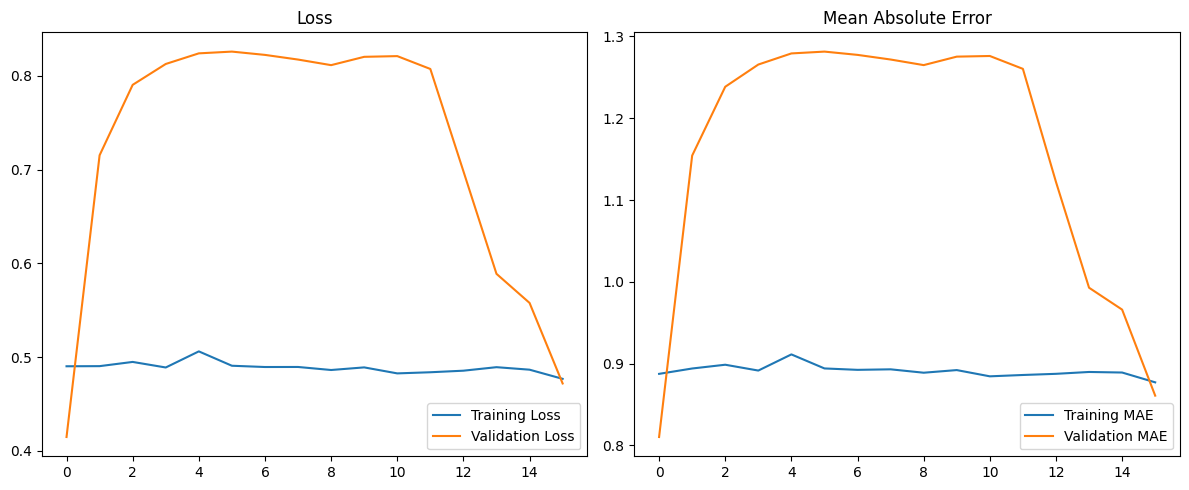

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    
    # Plot mean absolute error
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call this after training
plot_history(history)


---

<h2> 2nd Model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

In [13]:
def make_dataset(df, batch_size=32, shuffle=True):
    faces, labels = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            face, lbl = preprocess_row(row)
            faces.append(face)
            labels.append(lbl)
        except:
            continue  # skip unreadable
    X = np.stack(faces)
    y = np.stack(labels)

    print("✅ X shape:", X.shape)  # Should be (num_samples, 96, 96, 3)
    print("✅ y shape:", y.shape)  # Should be (num_samples, 2)

    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(len(X))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
train_ds = make_dataset(train_df)
test_ds = make_dataset(test_df, shuffle=False)

100%|██████████| 576/576 [00:01<00:00, 366.97it/s]


✅ X shape: (576, 96, 96, 3)
✅ y shape: (576, 2)


100%|██████████| 64/64 [00:00<00:00, 488.56it/s]

✅ X shape: (64, 96, 96, 3)
✅ y shape: (64, 2)


In [15]:
# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def build_model2(input_shape=(96, 96, 3)):
    inp = layers.Input(shape=input_shape)

    # Apply data augmentation only during training
    x = data_augmentation(inp)

    x = layers.Conv2D(32, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    # Use Global Average Pooling instead of Flatten
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(2, activation='tanh')(x)  # valence/arousal in [-1,1]

    model = models.Model(inputs=inp, outputs=out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.Huber(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

In [16]:
model2 = build_model2()
history2 = model2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
18/18 [==============================] - 7s 340ms/step - loss: 0.3493 - mean_absolute_error: 0.6657 - val_loss: 0.2766 - val_mean_absolute_error: 0.5702
Epoch 2/50
18/18 [==============================] - 6s 324ms/step - loss: 0.3222 - mean_absolute_error: 0.6339 - val_loss: 0.2742 - val_mean_absolute_error: 0.5645
Epoch 3/50
18/18 [==============================] - 6s 327ms/step - loss: 0.3250 - mean_absolute_error: 0.6385 - val_loss: 0.2654 - val_mean_absolute_error: 0.5494
Epoch 4/50
18/18 [==============================] - 6s 327ms/step - loss: 0.3107 - mean_absolute_error: 0.6190 - val_loss: 0.2577 - val_mean_absolute_error: 0.5396
Epoch 5/50
18/18 [==============================] - 4s 239ms/step - loss: 0.3127 - mean_absolute_error: 0.6243 - val_loss: 0.2562 - val_mean_absolute_error: 0.5371
Epoch 6/50
18/18 [==============================] - 6s 323ms/step - loss: 0.3050 - mean_absolute_error: 0.6161 - val_loss: 0.2568 - val_mean_absolute_error: 0.5422
Epoch 7/50
18/18

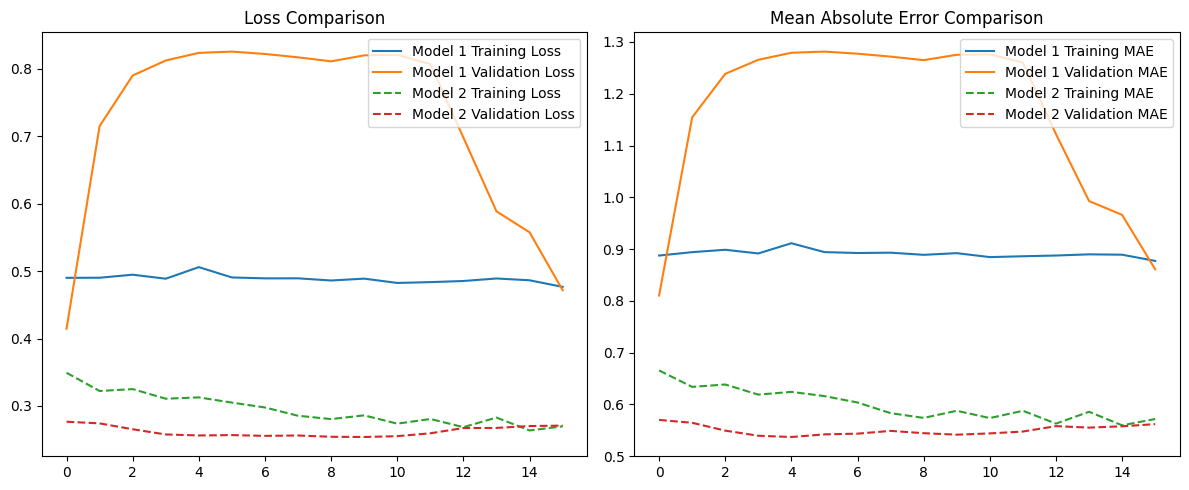

In [20]:
import matplotlib.pyplot as plt

def plot_comparison(history1, history2, epochs=16):
    plt.figure(figsize=(12, 5))

    # Slice the data to only show the first 'epochs' points
    loss1 = history1.history['loss'][:epochs]
    val_loss1 = history1.history['val_loss'][:epochs]
    loss2 = history2.history['loss'][:epochs]
    val_loss2 = history2.history['val_loss'][:epochs]

    mae1 = history1.history['mean_absolute_error'][:epochs]
    val_mae1 = history1.history['val_mean_absolute_error'][:epochs]
    mae2 = history2.history['mean_absolute_error'][:epochs]
    val_mae2 = history2.history['val_mean_absolute_error'][:epochs]

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(loss1, label='Model 1 Training Loss')
    plt.plot(val_loss1, label='Model 1 Validation Loss')
    plt.plot(loss2, label='Model 2 Training Loss', linestyle='--')
    plt.plot(val_loss2, label='Model 2 Validation Loss', linestyle='--')
    plt.title('Loss Comparison')
    plt.legend()

    # Plot mean absolute error
    plt.subplot(1, 2, 2)
    plt.plot(mae1, label='Model 1 Training MAE')
    plt.plot(val_mae1, label='Model 1 Validation MAE')
    plt.plot(mae2, label='Model 2 Training MAE', linestyle='--')
    plt.plot(val_mae2, label='Model 2 Validation MAE', linestyle='--')
    plt.title('Mean Absolute Error Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(history, history2)

In [21]:
#evaluate both models
loss, mae = model.evaluate(test_ds)
print(f"Model 1 - Loss: {loss:.4f}, MAE: {mae:.4f}")

loss2, mae2 = model2.evaluate(test_ds)
print(f"Model 2 - Loss: {loss2:.4f}, MAE: {mae2:.4f}")

2/2 [==============================] - 0s 86ms/step - loss: 0.4147 - mean_absolute_error: 0.8104
Model 1 - Loss: 0.4147, MAE: 0.8104
2/2 [==============================] - 0s 69ms/step - loss: 0.2539 - mean_absolute_error: 0.5416
Model 2 - Loss: 0.2539, MAE: 0.5416


Saving the best Model

In [23]:
model2.save(r"Emotion_Recognition_Model.h5")